In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
from tqdm import tqdm

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from utility_functions import *

In [2]:
pd.set_option('display.max_columns', None)

# Load data

load selected features data

In [ ]:
features_df = pd.read_csv('data_features_df_selected.csv')
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [5]:
feature_cols = [
    'cum_return_prev5d','cum_return_prev21d','cum_return_prev63d','cum_return_prev1d',
    'cum_return_09:30_10:00','cum_return_10:00_11:30','cum_return_11:30_13:30',
    'cum_return_13:30_15:15','relative_volume_prev09:30_11:30', # 'relative_volume_15:30',
    'relative_volume_prev11:30_13:30','relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00','relative_volume_10:00_11:30',
    'relative_volume_11:30_13:30','relative_volume_13:30_15:30',
    'volume_resid_return_corr','volume_raw_return_corr','volatility_1d',
    'volatility_21d_raw','volatility_21d_resid','volatility_63d_raw',
    'volatility_63d_resid','skewness_1d', # 'hlc_ratio','hlc_21mean',
    'skewness_21d_resid','skewness_63d_resid'
]
target_col = 'y'

# Training - Validation split

In [18]:
train_start = '2010-04-07'
train_end   = '2013-12-31'
val_start   = '2014-01-01'
val_end     = '2015-12-31'

X_train = features_df[features_df['Date'] < val_start][feature_cols]
y_train = features_df[features_df['Date'] < val_start]['y']
w_train = features_df[features_df['Date'] < val_start]['weight']

X_val = features_df[features_df['Date'] >= val_start][feature_cols]
y_val = features_df[features_df['Date'] >= val_start]['y']
w_val = features_df[features_df['Date'] >= val_start]['weight']

# Train

## lr=0.002, max_depth=10, alpha=0, lambda=0, gamma=0

In [22]:
# To DMatrix
dtrain = xgb.DMatrix(data=X_train, label=y_train, weight=w_train)
dval = xgb.DMatrix(data=X_val, label=y_val, weight=w_val)

# XGBoost Parameters
params = {
    'objective': 'reg:squarederror',  # regression problem
    'eval_metric': 'rmse',
    'learning_rate': 0.001,  # learning rate
    'max_depth': 10,  # max depth for tree
    'subsample': 0.8,  # subsample ratio
    'colsample_bytree': 0.8,  # subfeature ratio for every tree
    'alpha': 0,  # L1 regularization
    'lambda': 0,  # L2 regularization
    'gamma': 0,  # leaf penalty
    'seed': 42  # random seed
}

# Save train and val results
evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

# Train XGBoost model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=50,  # early stopping
    evals=evals,
    evals_result=evals_result,  # save results
    verbose_eval=10
)

[0]	train-rmse:0.01465	eval-rmse:0.01252
[10]	train-rmse:0.01463	eval-rmse:0.01252
[20]	train-rmse:0.01460	eval-rmse:0.01252
[30]	train-rmse:0.01458	eval-rmse:0.01252
[40]	train-rmse:0.01456	eval-rmse:0.01252
[50]	train-rmse:0.01453	eval-rmse:0.01252
[60]	train-rmse:0.01451	eval-rmse:0.01252
[70]	train-rmse:0.01449	eval-rmse:0.01252
[80]	train-rmse:0.01447	eval-rmse:0.01252
[90]	train-rmse:0.01444	eval-rmse:0.01252
[94]	train-rmse:0.01444	eval-rmse:0.01252


In [23]:
# Save model
model.save_model('xgb_model_0.model')
model.save_model('xgb_model_0.json')

c:\Users\52431\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## rmse, r2 results

In [24]:
# Model predict
y_train_pred = model.predict(dtrain)
y_val_pred = model.predict(dval)

# training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_r2_weighted = weighted_r2(y_train, y_train_pred, w_train)
train_corr = pd.Series(y_train_pred, index=y_train.index).corr(y_train)
train_corr_weighted = weighted_corr(y_train, y_train_pred, w_train)

# validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_r2_weighted = weighted_r2(y_val, y_val_pred, w_val)
val_corr = pd.Series(y_val_pred, index=y_val.index).corr(y_val)
val_corr_weighted = weighted_corr(y_val, y_val_pred, w_val)

# results output
print("XGBoost Results:")
print(f"Train MSE: {train_mse:.8f}, Train R^2: {train_r2:.8f}, Train R^2 Weighted: {train_r2_weighted:.8f}, Train Corr: {train_corr:.8f}, Train Corr Weighted: {train_corr_weighted:.8f}")
print(f"Val MSE:   {val_mse:.8f}, Val R^2:   {val_r2:.8f}, Val R^2 Weighted:   {val_r2_weighted:.8f}, Val Corr:   {val_corr:.8f}, Val Corr Weighted:   {val_corr_weighted:.8f}")

XGBoost Results:
Train MSE: 0.00021902, Train R^2: 0.02849868, Train R^2 Weighted: 0.02936963, Train Corr: 0.43976647, Train Corr Weighted: 0.45058413
Val MSE:   0.00016268, Val R^2:   -0.00009952, Val R^2 Weighted:   -0.00004941, Val Corr:   0.00291924, Val Corr Weighted:   0.00458088


## Feature importance plot

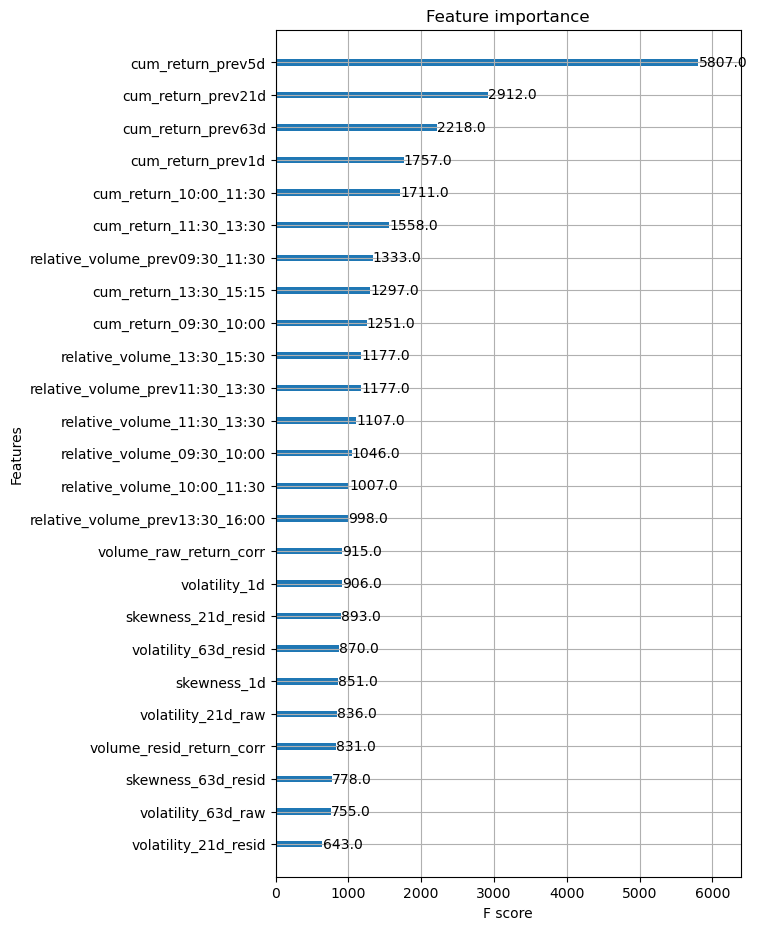

In [25]:
ax = xgb.plot_importance(model, importance_type='weight')
fig = ax.figure
fig.set_size_inches(6, 11)
plt.show()

# Grid search

In [26]:
import itertools

# Search list
max_depths = [8, 10]
subsamples = [0.8, 1.0]
colsample_bytrees = [0.8, 1.0]
reg_alphas = [0, 1]
reg_lambdas = [0, 1]
gammas = [0, 1]

best_score = float('inf')
best_params = None
best_model = None

# prepare data
dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train)
dval = xgb.DMatrix(X_val, label=y_val, weight=w_val)

for md, ss, csbt, ra, rl, gm in itertools.product(
    max_depths, subsamples, colsample_bytrees, reg_alphas, reg_lambdas, gammas
):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.0005,
        'max_depth': md,
        'subsample': ss,
        'colsample_bytree': csbt,
        'alpha': ra,
        'lambda': rl,
        'gamma': gm,
        'seed': 42
    }

    evals_result = {}
    evals = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        early_stopping_rounds=50,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=10
    )

    rmse_eval = evals_result['eval']['rmse'][-1]
    # Compare whether best rmse
    if rmse_eval < best_score:
        best_score = rmse_eval
        best_params = params
        best_model = model

    print(f"[GridSearch] lr=0.0005, max_depth={md}, subsample={ss}, "
          f"colsample_bytree={csbt}, alpha={ra}, lambda={rl}, gamma={gm}, "
          f"val_rmse={rmse_eval:.5f}")

print("Best params:", best_params)
print("Best RMSE:", best_score)

best_model.save_model('xgb_best_model.model')
best_model.save_model('xgb_best_model.json')

[0]	train-rmse:0.01465	eval-rmse:0.01252
[10]	train-rmse:0.01464	eval-rmse:0.01252
[20]	train-rmse:0.01463	eval-rmse:0.01252
[30]	train-rmse:0.01462	eval-rmse:0.01252
[40]	train-rmse:0.01461	eval-rmse:0.01252
[50]	train-rmse:0.01460	eval-rmse:0.01252
[60]	train-rmse:0.01459	eval-rmse:0.01252
[70]	train-rmse:0.01458	eval-rmse:0.01252
[80]	train-rmse:0.01457	eval-rmse:0.01252
[90]	train-rmse:0.01456	eval-rmse:0.01252
[94]	train-rmse:0.01455	eval-rmse:0.01252
[GridSearch] lr=0.0005, max_depth=8, subsample=0.8, colsample_bytree=0.8, alpha=0, lambda=0, gamma=0, val_rmse=0.01252
[0]	train-rmse:0.01465	eval-rmse:0.01252
[10]	train-rmse:0.01464	eval-rmse:0.01252
[20]	train-rmse:0.01463	eval-rmse:0.01252
[30]	train-rmse:0.01462	eval-rmse:0.01252
[40]	train-rmse:0.01461	eval-rmse:0.01252
[50]	train-rmse:0.01460	eval-rmse:0.01252
[60]	train-rmse:0.01459	eval-rmse:0.01252
[70]	train-rmse:0.01458	eval-rmse:0.01252
[80]	train-rmse:0.01457	eval-rmse:0.01252
[90]	train-rmse:0.01456	eval-rmse:0.01252
[

c:\Users\52431\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:50:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


## Best model predict results

In [27]:
# Model predict
y_train_pred = best_model.predict(dtrain)
y_val_pred = best_model.predict(dval)

# training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_r2_weighted = weighted_r2(y_train, y_train_pred, w_train)
train_corr = pd.Series(y_train_pred, index=y_train.index).corr(y_train)
train_corr_weighted = weighted_corr(y_train, y_train_pred, w_train)

# validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
val_r2_weighted = weighted_r2(y_val, y_val_pred, w_val)
val_corr = pd.Series(y_val_pred, index=y_val.index).corr(y_val)
val_corr_weighted = weighted_corr(y_val, y_val_pred, w_val)

# results output
print("XGBoost Best Model Results:")
print(f"Train MSE: {train_mse:.8f}, Train R^2: {train_r2:.8f}, Train R^2 Weighted: {train_r2_weighted:.8f}, Train Corr: {train_corr:.8f}, Train Corr Weighted: {train_corr_weighted:.8f}")
print(f"Val MSE:   {val_mse:.8f}, Val R^2:   {val_r2:.8f}, Val R^2 Weighted:   {val_r2_weighted:.8f}, Val Corr:   {val_corr:.8f}, Val Corr Weighted:   {val_corr_weighted:.8f}")

XGBoost Best Model Results:
Train MSE: 0.00022126, Train R^2: 0.01858087, Train R^2 Weighted: 0.01950798, Train Corr: 0.42364343, Train Corr Weighted: 0.43541646
Val MSE:   0.00016269, Val R^2:   -0.00015994, Val R^2 Weighted:   0.00005219, Val Corr:   0.00956629, Val Corr Weighted:   0.01210563


## Best model importance plot

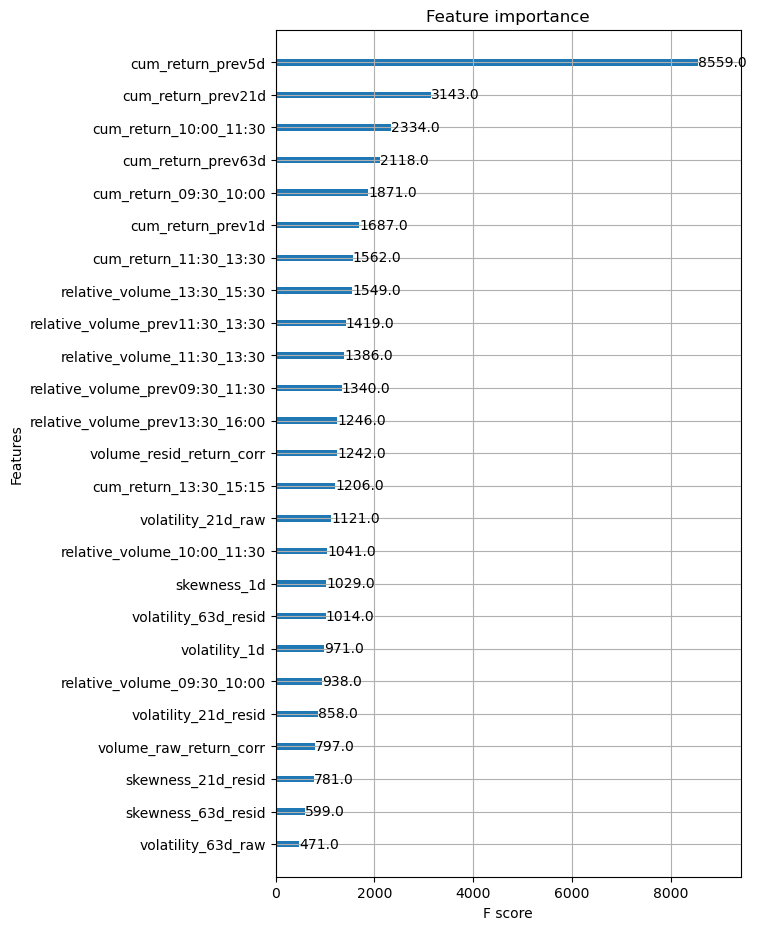

In [28]:
ax = xgb.plot_importance(best_model, importance_type='weight')
fig = ax.figure
fig.set_size_inches(6, 11)
plt.show()